In [16]:
import tensorflow as ts
from tensorflow import keras
import numpy as np
import tensorflow.keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.callbacks import Callback

import os
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import io

def custom_loss(y_true, y_pred,gamma, beta, e, x0, T,alpha,t):
    """
    Calculates the L2 norm of the difference between y_pred and a constant value, plus
    a scaled sum of y_pred, for each example in the batch. Returns the average L2 norm
    over all examples.

    Args:
    y_true: tensor of true labels
    y_pred: tensor of predicted labels

    Returns:
    A tensor representing the mean L2 norm over all examples.
    """
    
     # calculate the difference y_pred[i] - c * sum(y_pred)
    n = K.int_shape(y_pred)[1]
    hs = 1.0 / n
    H1 = alpha*e*(T-t)*(gamma-x0)
    intu = hs*K.sum(y_pred, axis=1, keepdims=True)
    aux2 = hs*K.cumsum(y_pred, axis=1)
    H2 = -alpha*e*hs*(K.sum(aux2, axis=1,keepdims=True)-K.cumsum(aux2, axis=1))
    H3 = e*(1-alpha)*(gamma-x0-intu)
    diff = H1+H2+H3-beta*y_pred
    
    # calculate the L2 norm for each example
    norma = K.sqrt(K.sum(K.square(diff), axis=1))/n
    
    # return the average L2 norm over all training examples
    return K.mean(norma)



class SavePredictions(Callback):
    def __init__(self, x_val):
        self.x_val = x_val
        self.predictions = []
    
    def on_epoch_end(self, epoch, logs={}):
        # Faz as previsões no conjunto de validação
        y_pred = self.model.predict(self.x_val)
        
        # Salva as previsões em uma lista
        self.predictions.append(y_pred)
        
        # Salva as previsões em um arquivo a cada 5 épocas
        if epoch % 10 == 0:
            np.save('solutions/din_1_fun_1_epoch{}.npy'.format(10000+epoch), y_pred)

def trimf(x,a,b,c):
    rs = np.nan
    if x<a or x>c:
        rs = 0
    elif x>=a and x<=b:
        rs = (x-a)/(b-a)
    elif x>b and x<=c:
        rs = (c-x)/(c-b)
    return rs

def dinamica(u,x,t,T):
    tv = np.space(0,T,len(u))
    hs = tv[1]
    aux = np.interp(t,tv,hs*np.cumsum(u))
    return x+aux,x-aux

def construir_sol(t,z,u,fuz):
    rs = np.zeros(shape=(len(z),len(t)))
    u = t[1]*np.cumsum(u)
    for i,vt in enumerate(t):
        for j,vz in enumerate(z):
            rs[j,i] = trimf(vz-u[i],fuz[0],fuz[1],fuz[2])
    return rs

def funcional(u,gamma, beta, e, x0, T,alpha):
    hs = T/len(u)
    w = hs*np.cumsum(u)
    phit = e*(6*w*w - 12*gamma*w + 12*x0*w + e*e + 6*gamma*gamma - 12*gamma*x0 + 6*x0*x0)/6
    Iu2 =  hs*np.sum(u*u)
    ju = 0.5*(1-alpha)*phit[-1]+0.5*alpha*hs*np.sum(phit)+0.5*beta*Iu2
    return ju

In [19]:
# parâmetros
gamma = 0.0
beta = 1/4.0
e = 1.0
x0 = 5.0
T = 1.0
alpha = 1

# Tamanho da entrada, número de neurônios nas camadas ocultas
n, n1 = 100, 5


# Dados de treinamento
X_train = np.linspace(0,1,n).reshape(1,n)
y_train = np.linspace(0,1,n).reshape(1,n)

# Criação do modelo
model = Sequential()

# Adicionando as camadas ao modelo
model.add(InputLayer(input_shape=(n,)))
model.add(Dense(n1, activation='relu'))
model.add(Dense(n, activation='linear'))

# Compilando o modelo
loss = lambda y_true, y_pred: custom_loss(y_true, y_pred, gamma, beta, e, x0, T, alpha, np.linspace(0,T,n))
model.compile(loss=loss, optimizer='adam')


# Treinando o modelo
save_predictions = SavePredictions(X_train)
model.fit(X_train, y_train, epochs=1001, callbacks=[save_predictions])

# Fazendo uma previsão
y_pred = model.predict(X_train).ravel()

Epoch 1/1001
1/1 [==============================] - 2s 2s/step - loss: 0.2898
Epoch 2/1001
1/1 [==============================] - 0s 115ms/step - loss: 0.2896
Epoch 3/1001
1/1 [==============================] - 0s 131ms/step - loss: 0.2894
Epoch 4/1001
1/1 [==============================] - 0s 145ms/step - loss: 0.2891
Epoch 5/1001
1/1 [==============================] - 0s 115ms/step - loss: 0.2889
Epoch 6/1001
1/1 [==============================] - 0s 193ms/step - loss: 0.2887
Epoch 7/1001
1/1 [==============================] - 0s 148ms/step - loss: 0.2885
Epoch 8/1001
1/1 [==============================] - 0s 232ms/step - loss: 0.2882
Epoch 9/1001
1/1 [==============================] - 0s 189ms/step - loss: 0.2880
Epoch 10/1001
1/1 [==============================] - 0s 135ms/step - loss: 0.2877
Epoch 11/1001
1/1 [==============================] - 0s 132ms/step - loss: 0.2875
Epoch 12/1001
1/1 [==============================] - 0s 291ms/step - loss: 0.2872
Epoch 13/1001
1/1 [=========

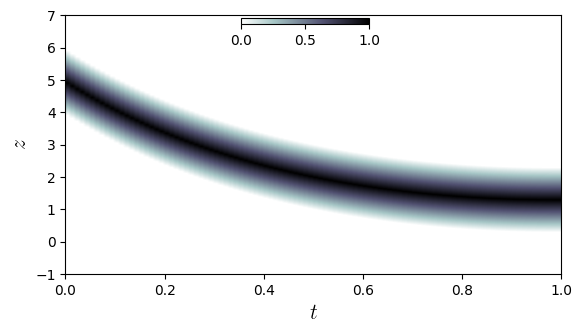

In [20]:
u = np.load("solutions/din_1_fun_1_epoch11000.npy").ravel()
t = np.linspace(0, T, len(u))
z = np.linspace(-1, x0 + 2 * e, 500)
M = construir_sol(t, z, u, [x0 - e, x0, x0 + e])

fig, ax = plt.subplots(figsize=(6.4,0.75*6.4)) # Define o tamanho da figura como 6 por 4

# Ajuste os limites da imagem para ocupar a maior área possível dentro da figura
im = ax.imshow(M, extent=[t.min(), t.max(), z.min(), z.max()], cmap='bone_r', origin='lower', aspect='auto')

ax.set_xlabel(r'$t$', fontsize=16, usetex=True)
ax.set_ylabel(r'$z$', fontsize=16, usetex=True)

pos = ax.get_position()

# cax = fig.add_axes([pos.x0, -0.05, pos.height, 0.05])
# cbar = fig.colorbar(im, cax=cax,orientation='horizontal')
# cbar.set_label(r'$p$', fontsize=16, usetex=True)
cbar = fig.colorbar(im, ax=ax,orientation='horizontal')
cbar.ax.set_position([0.4 ,0.825, 0.2,0.05])
# cbar.set_label(r'$p$', fontsize=16, usetex=True)
cbar.set_ticks([0,0.5,1])

plt.show()

In [21]:
directory = os.getcwd()
extensao = ".npy"
files = os.listdir(os.path.join(directory, "solutions"))

filtered_files = sorted([file for file in files if file.endswith(extensao) and "din_1_fun_1" in file])
num_iter = len(filtered_files)

# Cria uma lista para armazenar as imagens em memória
images = []

# Loop pelas iterações
umin,umax = np.inf, -np.inf
x = np.linspace(0, T,n)
Y,FU = [],[]
for i in range(num_iter):
    data = np.load("solutions/"+filtered_files[i])
    # Cria os dados do gráfico
    y = data.ravel()
    Y.append(y)
    umin = min(umin,min(y))
    umax = max(umax,max(y))
    FU.append(funcional(y,gamma,beta,e,x0,T,alpha))


for i in range(num_iter):
    # data = np.load("solutions/"+filtered_files[i])
    # # Cria os dados do gráfico
    # x = np.linspace(0, 1,n)
    # y = data.ravel()
    # umin = min(umin,min(y))
    # umax = max(umax,max(y))
    
    # Cria a figura e o eixo
    fig, ax = plt.subplots(figsize=(6.4,0.75*6.4))
    sns.lineplot(x=x, y=Y[i], ax=ax)
    ax.set(xlim=[0,1],ylim=[umin,umax])
    ax.set_xlabel(r'$t$',fontsize=16,usetex=True)
    ax.set_ylabel(r'$u(t)$',fontsize=16,usetex=True)
    pos = ax.get_position()
    
    # Adiciona o número da iteração no canto superior direito
    ax.text(0.95, 0.95, f'epoch: {10*i}', transform=ax.transAxes, ha='right', va='top')
    ax.text(pos.x0+0.1, 0.95, r'$J(u): {:.4f}$'.format(FU[i]), transform=ax.transAxes, ha='right', va='top',usetex=True)
    
    # Salva a figura em memória como uma imagem
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png', dpi=300)
    buffer.seek(0)
    image = Image.open(buffer)
    images.append(image)
    
    # Fecha a figura
    plt.close()

# Salva o GIF a partir das imagens em memória
images[0].save('animacao_din_1_fun_1.gif',
               save_all=True,
               append_images=images[1:],
               duration=100,
               loop=0)

# Apaga os arquivos numpy
# for file in filtered_files:
#     os.unlink(file)